In [1]:
run_path = "/DATA/phare/pharebook_data/tests/2stream/2strRefin"
#run_path = "/home/smets/codeS/fAr/runs/2strRefin"

mode = 1
timeChunk = (0, 41) #time interval for the linear phase
timeStride = 1.0 # will get time in interval every stride

import numpy as np
from numpy.fft import fft
import os
import h5py
from pyphare.pharesee.run import Run
from pyphare.pharesee.hierarchy import finest_field
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
def getMode(t, m):
    return np.absolute(fft(t)[m])

In [3]:
def get_times(path, chunk=None, stride=None):
    f = h5py.File(path, "r")
    allTimes = np.array(sorted([float(s.strip("t")) for s in list(f.keys())]))

    if chunk is None:
        chunk = (allTimes[0], allTimes[-1])
    if stride is None:
        stride = 1e-4

    times=[]
    for t in allTimes:
        if t in np.arange(chunk[0], chunk[1], stride):
            times.append(t)

            
    f.close()
    return times

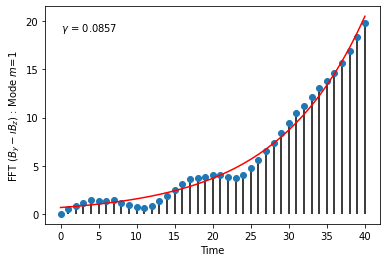

In [10]:
r = Run(run_path)
times = get_times(os.path.join(run_path, "EM_B.h5"), timeChunk, timeStride)
byz = np.array([])

for time in times:
    B = r.GetB(time)
    by, x = finest_field(B, "By")
    bz, x = finest_field(B, "Bz")
    mm = getMode(by-1j*bz, mode)
    byz = np.append(byz, mm)

def croaCroa(x, a, b):
    t1 = np.multiply(b, x)
    return a*np.exp(t1)

popt, pcov = curve_fit(croaCroa, times, byz, p0=[0.1, 0.1])

plt.stem(times, byz, linefmt='-k', basefmt=' ', use_line_collection=True)
plt.plot(times, croaCroa(times, popt[0], popt[1]), color='red')

plt.xlabel("Time")
plt.ylabel("FFT ($B_y - \imath B_z$) : Mode m=1")
plt.text(0, 19, "$\gamma$ = {:6.4f}".format(popt[1]))

plt.savefig("gamma.pdf")
plt.show()